# Wine Classification

## Summary
This project illustrates how our team endeavoured to build a classification model to predict whether a wine was red or white based on a set of wine quality features (ex. pH, residual sugars, etc.).  Four models were investigated with the best one being RBF SVM. It performed extremely well on our test data, with an accuracy of 0.9969 and f1 score of 0.9979. While there were still false positives and false negatives, indicated by the scores being less than one, this is not of great concern to us. Since we are not dealing with life-threatening or possible adverse outcomes, should a prediction be incorrect, the high level of precision in our model has given us confidence to use it in production.

# Introduction
Red or white? This is a question that countless dinner guests are asked every evening. Some know exactly what they like and others are more open to exploring something new and exciting. And just like the consumer, wine producers have a vested interest in this question. However, they aren’t looking at the wine through a glass, but at the very chemistry that makes up each and every nuanced flavour. They are asking: What does the chemistry say this wine is?

Our goal in this analysis is to see if we can develop a machine learning model to predict whether a wine will be classified as either white or red, based on a sample of wine chemical characteristics. This would allow the industry to be able to confirm their wines not only on a visual aspect but on a chemical level as well. We are using a dataset of wine quality for wines from the northern region of Portugal that consists of several chemical features: fixed acidity, pH, citric acid, sulphates, residual sugar and several others.

There may be a time that industry producers, small and large-alike, want to dive into how their wines measure up when compared to others. This could be confirming what is already known or helping to make that key distinction when a winemaker creates a blend of white and red and would like to know how best to market their product.

For example, it may be the case that a wine visually looks like a red, but that may not mean it chemically acts like one. Our model will be able to make that distinction and report back what the chemistry says.

Of course, there may be classifications that don’t align with what the wine is visually or the goal of the winemaker. In these cases, it may be due to variation in the model and the prediction probability not being reasonably high for either a red or white. While this may be seen as a disadvantage, it could also provide additional insights regarding the chemical quality of the wine in question. (I.e. It could be produced as a white wine, but with some underlying qualities of red wine.) 

With a proper understanding of our model, the input data, and final prediction, we hope that it will provide the wine industry with another way of viewing and marketing their product to the next couple dining out.

# Imports

In [18]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    cross_validate,
    train_test_split,
    cross_val_predict
)

# Exploratory Data Analysis

## Part 1: Data Ingestion & Data Wrangling  
First, we download the raw red and white wine datasets programmatically into `data/raw/` to ensure reproducibility.

In [19]:
import requests
from pathlib import Path

raw_dir = Path("data/raw")
raw_dir.mkdir(parents=True, exist_ok=True)

urls = {
    "red":  "https://archive.ics.uci.edu/static/public/186/winequality-red.csv",
    "white": "https://archive.ics.uci.edu/static/public/186/winequality-white.csv"
}

for wine_type, url in urls.items():
    out_path = raw_dir / f"winequality-{wine_type}.csv"
    if not out_path.exists():
        out_path.write_bytes(requests.get(url).content)

Since the raw data has no NA values, this section begins with loading the red wine and white wine datasets from `data/raw/` directory separately, adding labels indicating the wine type, and combining them into a single unified dataset for further analysis.  

In [20]:
path_red = "data/raw/winequality-red.csv"
path_white = "data/raw/winequality-white.csv"
df_red = pd.read_csv(path_red, sep=";")
df_white = pd.read_csv(path_white, sep=";")

Below adding two new columns:  
 - `wine_type`: `red` for red wine, `white` for white wine. This column is used only for EDA and will not be included as a feature for classification.
 - `target`: `0` for red wine, `1` for white wine, which is the variable to be predicted.

In [21]:
df_red["wine_type"] = "red"
df_white["wine_type"] = "white"
df_red["target"] = 0
df_white["target"] = 1

Then merging the datasets and removing `quality` column:
 - two datasets are concatenated row-wise into one dataframe called `df_merge`
 - `quality` score is highly informative and could lead to data leakage if used as a feature when predicting wine type, therefore, we drop it from `df_merge`.

In [22]:
df_merge = pd.concat([df_red, df_white], axis=0).reset_index(drop=True)
df_merge = df_merge.drop(columns=["quality"])
df_merge.columns = df_merge.columns.str.replace(" ", "_")
df_merge

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,wine_type,target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,red,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,red,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,red,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,red,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,red,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,white,1
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,white,1
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,white,1
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,white,1


## Part 1.2 Data Validation 
This section performs the validation checks to ensure the data entered into the pipeline is standardized and validated to ensure smooth functioning of the analysis performed in the next sections.

In [6]:
df_merge["wine_type"].value_counts()

wine_type
white    4898
red      1599
Name: count, dtype: int64

#### 1.2.1 Check for empty Dataframe:

In [ ]:
if len(df_merge) == 0:
    raise ValueError("The merged dataset is empty.")

#### 1.2.2 Check for expected columns


In [26]:
# Note: 'quality' was dropped, so we check for the remaining ones
expected_columns = {
    "fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar",
    "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density",
    "pH", "sulphates", "alcohol", "wine_type", "target"
}

if not expected_columns.issubset(df_merge.columns):
    missing = expected_columns - set(df_merge.columns)
    raise ValueError(f"Missing columns: {missing}")

#### 1.2.3 Check for missing values

In [27]:
#The notebook mentions raw data has no NAs, but good to verify
if df_merge.isnull().any().any():
    raise ValueError("Unexpected missing values found in the dataset.")

#### 1.2.4 Check for correct data types in each column

#### 1.2.5 Duplicate Observation Check

#### 1.2.6 Check for outlier or anonymous values

#### 1.2.7 Check for correct category levels 
- I dont know what this exactly is, remove if unnecessary.

#### 1.2.8 Correlation check between explanatory and response variables.

#### 1.2.9 Correlation check just between feature(explanatory) variables

The final combined dataset contains:
 - all numeric chemical features
 - `wine_type` (categorical, only for EDA visualization), with 4,898 white wine samples and 1599 red wine samples.
 - `target` (binary variable for classification)  
  
Now this dataframe is not imbalanced and clean, it is ready for EDA and modeling.

## Part 2: Exploratory Data Analysis  
This section summarizes the data structure and important statistical properties that are related to the features of this wine classification project.
### 1. Data Structure

In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_merge, test_size=0.2, random_state=123)
df_info = train_df.info()
df_info

<class 'pandas.core.frame.DataFrame'>
Index: 5197 entries, 6452 to 3582
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         5197 non-null   float64
 1   volatile_acidity      5197 non-null   float64
 2   citric_acid           5197 non-null   float64
 3   residual_sugar        5197 non-null   float64
 4   chlorides             5197 non-null   float64
 5   free_sulfur_dioxide   5197 non-null   float64
 6   total_sulfur_dioxide  5197 non-null   float64
 7   density               5197 non-null   float64
 8   pH                    5197 non-null   float64
 9   sulphates             5197 non-null   float64
 10  alcohol               5197 non-null   float64
 11  wine_type             5197 non-null   object 
 12  target                5197 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 568.4+ KB


The `.info()` output shows:  
 - No missing values
 - 11 numerical features

Confirms that the dataset is clean and ready for analysis.

In [8]:
df_summary = train_df.describe()
df_summary

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,target
count,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.00000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000
mean,7.215519,0.338230,0.320073,5.451472,0.056028,30.73629,116.182990,0.994690,3.217897,0.530069,10.493335,0.756206
std,1.298654,0.164058,0.146037,4.769121,0.035179,17.90455,56.898123,0.003019,0.160178,0.149313,1.200092,0.429411
min,3.800000,0.080000,0.000000,0.600000,0.012000,1.00000,6.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.00000,78.000000,0.992300,3.110000,0.430000,9.500000,1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.00000,118.000000,0.994890,3.210000,0.500000,10.300000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,42.00000,156.000000,0.996990,3.320000,0.600000,11.300000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.00000,440.000000,1.038980,4.010000,2.000000,14.900000,1.000000


Using `.describe()` to check summary statistics for all numerical variables.  
Key observations:
 - **Residual sugar**, **free sulfur dioxide**, and **total sulfur dioxide** have wide ranges and right-skewed distributions with extreme outliers.
 - **pH**, **alcohol**, **density**, **chlorides** and **critic acid** have small standard deviations, showing relatively tight distributions.

These statistics provide insight into which variables may separate wine types well.

### 2. Overall Univariate Distributions
Overall histogram patterns:
 - Many features (e.g. **residual sugar**, **chlorides**, **sulphates**) show right-skewness, which means most wines fall in lower ranges with a few extreme values, whereas **alchohol** is slightly right-skewed.
 - The distribution of **dnesity** and **pH** are similar to Normal distribution.


In [9]:
import altair as alt
alt.data_transformers.enable("vegafusion")

numeric_cols = train_df.select_dtypes('number').columns.tolist()

plots = []
for col in numeric_cols:
    plot = alt.Chart(train_df).mark_bar().encode(
        alt.X(
            col, type="quantitative",
            bin=alt.Bin(maxbins=40),
            title=f"{col} (binned)"
        ),
        alt.Y("count()",title="Count").stack(False),
    ).properties(
        width=140,
        height=110
    )
    plots.append(plot)

hist_plot = alt.concat(*plots, columns=3).properties(
    title="Univariate Distributions of Numeric Features"
).configure_title(fontSize=20)
hist_plot

alt.ConcatChart(...)

### 3. Distributions of Features by Wine Type
Key distribution differences between red (0) and white (1) wine:
- Overall, most features for both wine types show **strongly right-skewed distributions**. The distribution of **pH** looks close to bell-shaped. For pH, the **red wines have higher pH than white wines**, so the whites are more acidic.
- For **fixed_acidity**, **volatile_acidity**, **citric_acid**, **chlorides**, and **sulphates**, the **white wines have higher density at the lower end of the scale**, so whites here look "lighter" and cleaner on these chemistry dimensions.
- **Alcohol** levels tend to be higher in **red wines**, while white wines peak at slightly lower alcohol values. Combined with their higher pH, this suggests that whites are lighter but sweeter and more acidic.

In [10]:
plot_2 = []
numeric_cols_2 = numeric_cols.copy()
numeric_cols_2.remove("target")
target_col = "target"

for col2 in numeric_cols_2:
    kde_plot = alt.Chart(train_df).transform_density(
        density=col2,
        groupby=[target_col],
        as_=[f"{col2}", "kde_density"],
        steps=200
    ).mark_line().encode(
        alt.X(f"{col2}:Q", title=col2),
        alt.Y("kde_density:Q", title="KDE Density").stack(False),
        alt.Color(f"{target_col}:N", title="Wine Type")
    ).properties(
        width=130,
        height=100
    )
    plot_2.append(kde_plot)

kde_final = alt.concat(*plot_2, columns=3).resolve_scale(
    x="independent",
    y="independent"
).properties(
    title="Distributions of Different Features by Wine Type"
).configure_title(fontSize=20)
kde_final

alt.ConcatChart(...)

### 4. Pairwise Correlations
Overall correlation patterns:
 - **Density** is strongly positively correlated with **residual sugar**, and **free sulfur dioxide** is strongly correlated with **total sulfur dioxide**.
 - **Alcohol** is negatively correlated with **density**, consistent with wine chemistry.
 - **pH** is negatively correlated with **fixed acidity**, showing the expected inverse relationship.


In [11]:
corr = train_df[numeric_cols].corr().reset_index().melt("index")
corr.columns = ["feature_x", "feature_y", "correlation"]

heatmap = (
    alt.Chart(corr)
    .mark_rect()
    .encode(
        alt.X("feature_x:N", title="Feature X"),
        alt.Y("feature_y:N", title="Feature Y"),
        color=alt.Color(
            "correlation:Q", scale=alt.Scale(domain=(-1, 1),scheme="purpleorange"),
            title="Correlation"
        ),
        tooltip=["feature_x", "feature_y", "correlation"]
    )
    .properties(width=300, height=300, title="Correlation Heatmap")
)

heatmap = heatmap.properties(
    title="Correlation Heatmap of Wine Chemical Features"
).configure_title(fontSize=15)
heatmap

alt.Chart(...)

# Classification Model

- Split data into train and test set
- Drop `wine_type` since it is converted into target as binary column
- seperate data set into features and target

In [12]:
train_df, test_df = train_test_split(df_merge.drop(columns=["wine_type"]), test_size=0.2, random_state=123)

X_train, y_train = train_df.drop(columns=["target"]), train_df["target"]
X_test, y_test = test_df.drop(columns=["target"]), test_df["target"]

### Pipeline
- Since all features are numerical, `StandardScaler` from sklearn is applied to all features to ensure all features have equal weights in the classifier model.
- iterate through each model to find the optimal classifier model

In [13]:
preprocessor = StandardScaler()

models = {
    "dummy": DummyClassifier(random_state = 123),
    "Decision Tree": DecisionTreeClassifier(random_state = 123),
    "KNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state = 123),
    "Logistic Regression": LogisticRegression(max_iter = 2000, random_state = 123),
}

The following code for `mean_std_cross_val_scores` is adapted from DSCI 571 lab 2

In [14]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.4f (+/- %0.4f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

### Iterate through each model

In [15]:
results_dict = {}

for model_name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results_dict[model_name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, cv = 5, return_train_score = True
    )

results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.0045 (+/- 0.0022),0.0024 (+/- 0.0007),0.7562 (+/- 0.0004),0.7562 (+/- 0.0001)
Decision Tree,0.0414 (+/- 0.0062),0.0022 (+/- 0.0004),0.9823 (+/- 0.0059),0.9997 (+/- 0.0002)
KNN,0.0080 (+/- 0.0017),0.0652 (+/- 0.0129),0.9921 (+/- 0.0030),0.9941 (+/- 0.0006)
RBF SVM,0.1010 (+/- 0.0129),0.0363 (+/- 0.0061),0.9952 (+/- 0.0021),0.9966 (+/- 0.0005)
Logistic Regression,0.0087 (+/- 0.0030),0.0013 (+/- 0.0001),0.9927 (+/- 0.0034),0.9937 (+/- 0.0013)


The performance of all models are pretty similar for all models except for the Dummy classifier.
While RBF SVM performs the best with minimum standard deviation in validation score.

# Results

### Confusion Matrix for each model

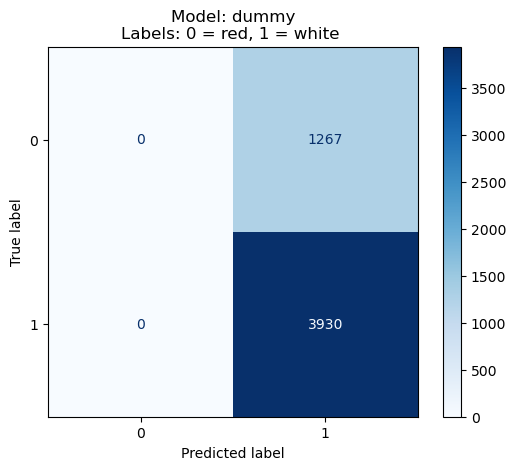

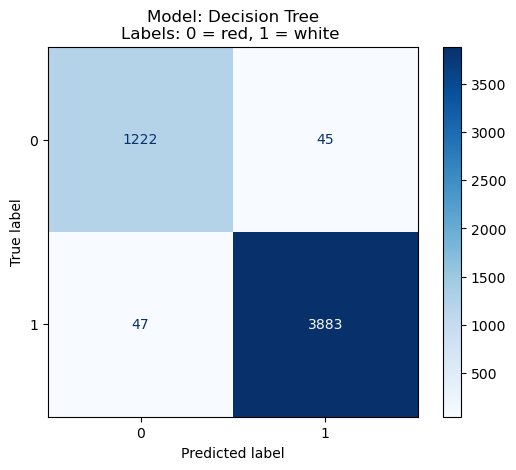

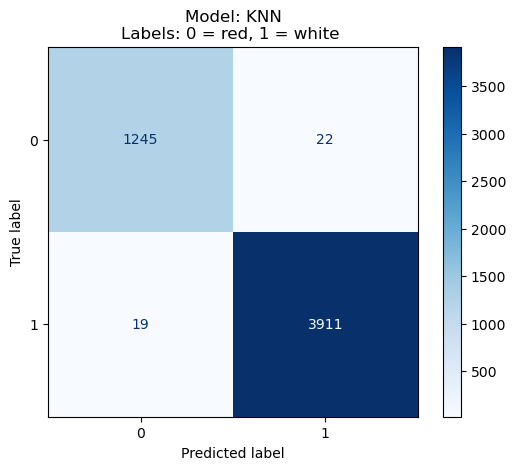

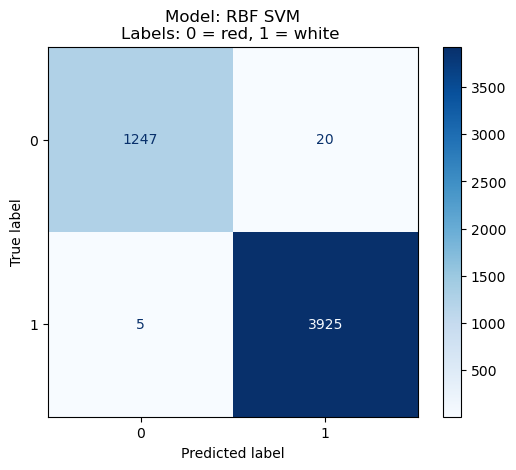

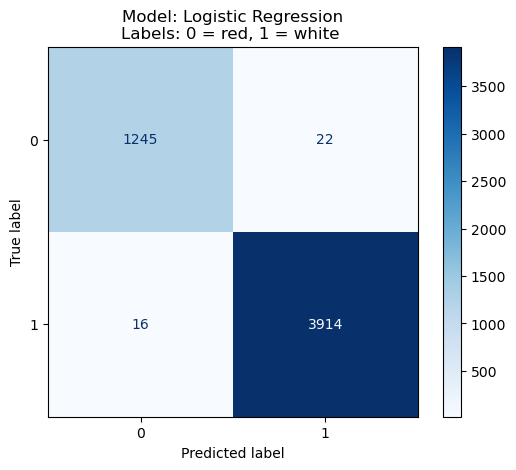

In [16]:
for model_name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    ConfusionMatrixDisplay(confusion_matrix(y_train, cross_val_predict(pipe, X_train, y_train))).plot(cmap='Blues')
    plt.title("Model: {}\nLabels: 0 = red, 1 = white ".format(model_name))
    

### Scoring on test data
- other scoring metrics are calculated on the test data since the accuracy is pretty similar for all models

In [17]:
from sklearn.metrics import recall_score, precision_score, accuracy_score
from collections import defaultdict
score_dict = defaultdict(dict)

def calculate_f1(precision, recall):
    """F1 = 2 * precision * recall / (precision + recall)"""
    return 2 * precision * recall / (precision + recall)

for model_name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    pipe.fit(X_train, y_train)
    prediction = pipe.predict(X_test)

    accuracy = accuracy_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    
    score_dict[model_name]["accuracy"] = accuracy
    score_dict[model_name]["recall"] = recall
    score_dict[model_name]["precision"] = precision
    score_dict[model_name]["f1"] = calculate_f1(precision, recall)

pd.DataFrame(score_dict).T

,accuracy,recall,precision,f1
dummy,0.744615,1.000000,0.744615,0.853616
Decision Tree,0.990769,0.993802,0.993802,0.993802
KNN,0.992308,0.993802,0.995859,0.994829
RBF SVM,0.996923,0.998967,0.996907,0.997936
Logistic Regression,0.992308,0.995868,0.993814,0.994840


The RBF SVM model performs the best on the test data as expected

# Discussion
We found that all of the models that we tested preformed much better than our Dummy Classifier. Subsequently, comparing our models individually, each one performed well. However, the model that had the highest cross-validation score was RBF SVM at 0.9952. Since all models scored high (>0.99), we included them in calculating accuracy, recall, precision and f1 on our test data. Here again, we see RBF SVM performing the best with the highest scores in each one of these metrics (0.9969, 0.9989, 0.9969, and 0.9979 respectively).

The metric of focus for our analysis was accuracy. Our primary aim was to ensure that we were correctly predicting whether or not a wine was red or white. Although we were looking towards accuracy, we can also see from our confusion matrices that the test recall and precision scores were high resulting in the lowest false positives and false negatives (20 and 5, during training). While our model was not being explicitly optimized regarding precision and recall, having these relatively small incorrect predictions from our training data and higher test scores adds to the robustness and our confidence of the model.

All four of our potential models exceeded our expectations. We expected them to do well, however, were pleased with the final results and scoring. There were some key features that led us to expect at least one well performing model. These were highlighted during our Exploratory Data Analysis and can be seen in our Distributions of Different Features by Wine Type and Pairwise Correlations visualizations. By analyzing the various density plots, we were able to see that there were several noticeable differences between red and white wines for several different features. There appeared to be several distributions with varying levels of overlap that increased our confidence that any potential model would be able to correctly predict red or white with a reasonable level of accuracy. For example, we saw different distributions for the volatile acidity and pH features. Our pairwise correlations showed a varying level of correlations among all the different features. This was an interesting part of the analysis as highly correlated free sulfur dioxide and sulfates made sense, while the negatively correlated alcohol and density got us to think deeper into the chemical nature of the wine.

These findings allow us to present a model that we can offer to winemakers and industry stakeholders to use in their business needs. Without having to spend the resources and time to create new wine products, a business can focus on the important features and from there decide on what wine to produce. For example, if a business was interested in making and marketing a wine that was low sugar and low in acidity (along with the other features), our model would help determine the type that should be produced. This is in addition to using the model to predict what type of wine an already produced wine is.

Our current analysis was only for the classification between two different types of wine: red and white. It would be interesting to see if we could expand this to include additional types of wine. We could look at including quality data for rose and sparkling wines. Additionally, if this new model worked well, it would be interesting to see if we could further generalize and make an all-purpose model that could be used to predict different types of alcohols based solely on chemical quality composition. This could possibly be useful, not only in the liquor industry, but in tangential industries that rely on models to predict unknown substances from a sample. (For example, forensics comes to mind.)

# References
Cortez, P., Cerdeira, A.L., Almeida, F., Matos, T., & Reis, J. (2009). Modeling wine preferences by data mining from physicochemical properties. Decis. Support Syst., 47, 547-553.

Cortez, P., Cerdeira, A., Almeida, F., Matos, T., & Reis, J. (2009). Wine Quality [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C56S3T.

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, E. (2011). Scikit-learn: Machine Learning in Python. *Journal of Machine Learning Research*, *12*, 2825–2830.

VanderPlas et al., (2018). Altair: Interactive Statistical Visualizations for Python. Journal of Open Source Software, 3(32), 1057, https://doi.org/10.21105/joss.01057